In [ ]:
pip install pandas numpy lifelines matplotlib seaborn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter
from statsmodels.stats.outliers_influence import variance_inflation_factor


🔹 Warning: Non-numeric columns detected, dropping: ['gender_Male', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']

🔹 Hazard Ratios (Exponentiated Coefficients):
covariate
SeniorCitizen                            1.047852
MonthlyCharges                           1.002898
TotalCharges                             0.999624
gender_Male                              0.

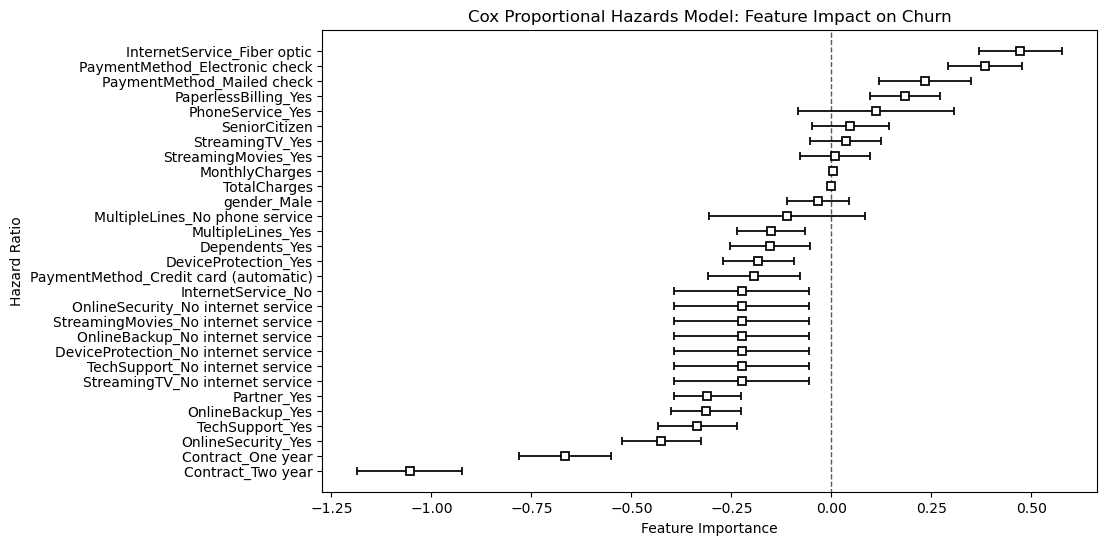

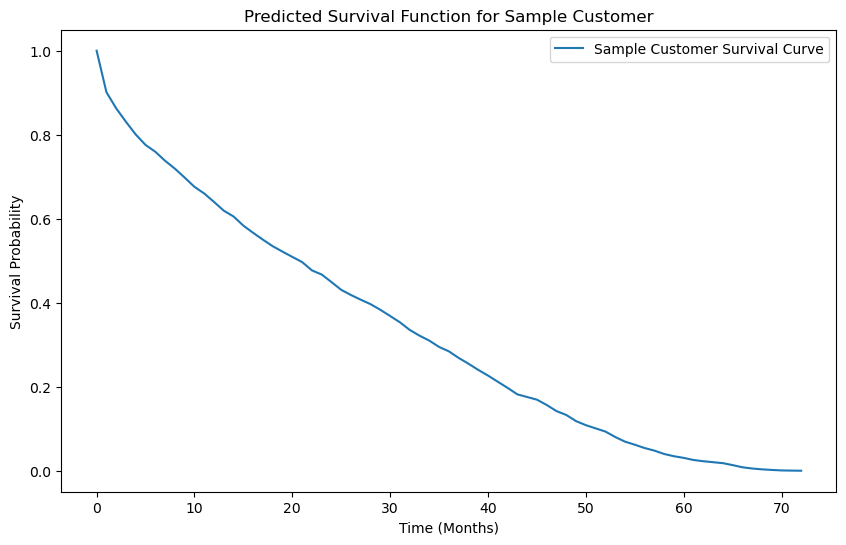

In [ ]:
# Load dataset (Update file path)
file_path = "/content/drive/MyDrive/Colab Notebooks/Datasets/Telco-Customer-Churn.csv"  # Replace with your file
df = pd.read_csv(file_path)

# Convert 'Churn' to binary (1 = Churned, 0 = Not Churned)
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

# Convert 'TotalCharges' to numeric (handling empty strings)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Fill missing values with median
# Fill missing values for numeric columns only
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())


# Convert categorical variables into numerical using One-Hot Encoding
categorical_cols = ["gender", "Partner", "Dependents", "PhoneService", "MultipleLines", 
                    "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", 
                    "TechSupport", "StreamingTV", "StreamingMovies", "Contract", 
                    "PaperlessBilling", "PaymentMethod"]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Rename 'tenure' column to 'Duration' for Cox model
df.rename(columns={"tenure": "Duration"}, inplace=True)

# Check for constant columns (which cause singularity)
constant_cols = [col for col in df.columns if df[col].nunique() == 1]
if constant_cols:
    print("\n🔹 Dropping constant columns:", constant_cols)
    df.drop(columns=constant_cols, inplace=True)

# Remove customerID if it exists
if "customerID" in df.columns:
    df.drop(columns=["customerID"], inplace=True)

# Define features for VIF computation
X = df.drop(columns=["Churn", "Duration"])  # Exclude target variables

# Ensure all values in X are numeric
X = X.apply(pd.to_numeric, errors="coerce")

# Check for non-numeric columns
non_numeric_cols = X.select_dtypes(exclude=['number']).columns.tolist()
if non_numeric_cols:
    print("\n🔹 Warning: Non-numeric columns detected, dropping:", non_numeric_cols)
    X.drop(columns=non_numeric_cols, inplace=True)

# Handle missing or infinite values
X.fillna(X.median(), inplace=True)
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)

# Recompute VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Drop variables with very high VIF (> 10)
high_vif_features = vif_data[vif_data["VIF"] > 10]["Feature"].tolist()
if high_vif_features:
    print("\n🔹 Dropping highly collinear variables:", high_vif_features)
    df.drop(columns=high_vif_features, inplace=True)




# # Remove multicollinear variables using Variance Inflation Factor (VIF)
# X = df.drop(columns=["customerID", "Churn", "Duration"])  # Features only
# X = X.apply(pd.to_numeric, errors="coerce")  # Ensure all are numeric
# X.fillna(X.median(), inplace=True)  # Fill NaN
# X.replace([np.inf, -np.inf], np.nan, inplace=True)
# X.dropna(inplace=True)  # Remove any remaining NaN rows

# # Compute VIF
# vif_data = pd.DataFrame()
# vif_data["Feature"] = X.columns
# vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# # Drop variables with very high VIF (> 10)
# high_vif_features = vif_data[vif_data["VIF"] > 10]["Feature"].tolist()
# if high_vif_features:
#     print("\n🔹 Dropping highly collinear variables:", high_vif_features)
#     df.drop(columns=high_vif_features, inplace=True)

# Define survival data (time: Duration, event: Churn)
survival_df = df[["Duration", "Churn"] + [col for col in df.columns if col not in ["customerID", "Churn", "Duration"]]]

# Fit Cox Proportional Hazards Model with penalization for stability
cph = CoxPHFitter(penalizer=0.1)
cph.fit(survival_df, duration_col="Duration", event_col="Churn")

# Display hazard ratios
print("\n🔹 Hazard Ratios (Exponentiated Coefficients):")
print(np.exp(cph.summary["coef"]))

# Plot feature importance (hazard ratios)
plt.figure(figsize=(10, 6))
cph.plot()
plt.title("Cox Proportional Hazards Model: Feature Impact on Churn")
plt.xlabel("Feature Importance")
plt.ylabel("Hazard Ratio")
plt.show()

# Predict survival function for a sample customer (Fixing the ValueError)
sample_customer = survival_df.drop(columns=["Churn"]).sample(n=1, random_state=42)  # Pick 1 random customer

# Predict survival curve for the selected customer
contract_survival = cph.predict_survival_function(sample_customer)

# Plot the survival function
plt.figure(figsize=(10, 6))
plt.plot(contract_survival.index, contract_survival.iloc[:, 0], label="Sample Customer Survival Curve")
plt.legend()
plt.title("Predicted Survival Function for Sample Customer")
plt.xlabel("Time (Months)")
plt.ylabel("Survival Probability")
plt.show()

